<a href="https://colab.research.google.com/github/HunderlineK/notebooks/blob/main/Model_Subclassing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [ ]:
# Build the model

class MyModel(Model):
    def __init__(self, units):
        super(MyModel, self).__init__()
        self.dense = tf.keras.layers.Dense(units)
    def call(self, inputs, training=False):
        return self.dense(inputs)

In [ ]:
# Print the model summary

model = MyModel(1)
model.build((None, 1))
model.summary()

Model: "my_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [ ]:
# Create a custom layer

class SimpleDense(Layer):
  def __init__(self, input_dim, units):
    super(SimpleDense, self).__init__()
    self.units = units
    self.w = self.add_weight(shape=(input_dim, units), initializer=tf.random_normal_initializer())
    self.b = self.add_weight(shape=(units), initializer=tf.zeros_initializer())
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

simple_dense = SimpleDense(3, 1)
x = [tf.constant((4, 3, 2), dtype="float32")]
print(simple_dense(x))
print(simple_dense.trainable_weights)

tf.Tensor([[-0.47028118]], shape=(1, 1), dtype=float32)
[<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.10946687],
       [-0.0304388 ],
       [ 0.02945134]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [ ]:
# Specify trainable weights


class SimpleDense(Layer):
  def __init__(self, input_dim, units):
    super(SimpleDense, self).__init__()
    self.units = units
    self.w = self.add_weight(shape=(input_dim, units), initializer=tf.random_normal_initializer())
    self.b = self.add_weight(shape=(units), initializer=tf.zeros_initializer(), trainable=False)
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

simple_dense = SimpleDense(3, 1)
x = [tf.constant((4, 3, 2), dtype="float32")]

In [ ]:
print('trainable weights:', simple_dense.trainable_weights)
print('non-trainable weights:', simple_dense.non_trainable_weights)

trainable weights: [<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.05632761],
       [0.0780715 ],
       [0.04850844]], dtype=float32)>]
non-trainable weights: [<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [ ]:
# Create a custom layer to accumulate means of output values

class ActivationsMean(Layer):
  def __init__(self, units, input_dim):
    super(ActivationsMean, self).__init__()
    self.units = units
    self.w = self.add_weight(shape=(input_dim, units), initializer=tf.random_normal_initializer())
    self.b = self.add_weight(shape=(units), initializer=tf.zeros_initializer())
    self.num_calls = tf.Variable(0)
    self.activations_sum = tf.Variable(tf.zeros(units))
  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.num_calls.assign_add(inputs.shape[0])
    self.activations_sum.assign_add(tf.reduce_sum(activations, axis=0))
    return activations, self.activations_sum / tf.cast(self.num_calls, dtype="float32")
  
activations_mean = ActivationsMean(units=3, input_dim=5)

In [ ]:
# Test the layer

y, activation_means = activations_mean(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.09037036 -0.2020526   0.16883661]


In [ ]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [ ]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):
    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.dense_1 = SimpleDense(input_dim_1, units_1)
        self.dropout_1 = MyDropout(0.7)
        self.dense_2 = SimpleDense(units_1, units_2)
        self.dropout_2 = MyDropout(0.7)
        self.dense_3 = SimpleDense(units_2, units_3)
           
    def call(self, inputs):
        # Define forward pass
        h = self.dense_1(inputs)
        h = self.dropout_1(h)
        h = self.dense_2(h)
        h = self.dropout_2(h)
        return self.dense_3(h)

In [ ]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[ 1.1130168  -1.9405086  -0.9035058   4.8536034  -0.19616146 -0.19793004
  -0.4119551  -2.231533    0.21389516  1.5264114  -0.06521636  2.8056967
   2.1658113   0.08040199  0.8826734  -1.6868404  -0.7327321   1.4152582
  -3.535544    0.17693329 -2.971482   -1.9056319  -2.935541   -0.13452011
  -0.00566787 -2.4229639  -4.081917    2.0636582   2.8587728  -1.7552518
  -1.8000066   0.6231221  -3.164719   -1.6298279   0.29169396  1.183894
   0.17411514 -3.159477   -0.20334071  3.343568    1.4505521   2.4944737
   0.36954775 -2.3430796   3.0455208   1.8699613 ]], shape=(1, 46), dtype=float32)
Model: "my_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_dense_22 (SimpleDense multiple                  640064    
_________________________________________________________________
my_dropout_12 (MyDropout)    multiple                  0         
____________________________________________

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

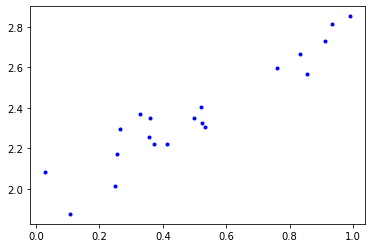

In [ ]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

w=1
m=0.75
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
# Build a custom layer for the linear regression model

class LinearRegression(Layer):
  def __init__(self):
    super(LinearRegression, self).__init__()
  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], 1), initializer=tf.random_normal_initializer())
    self.b = self.add_weight(shape=(1), initializer=tf.zeros_initializer())
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b
  
linear_regression = LinearRegression()
linear_regression.trainable_variables

[]

#### Define the loss function

In [ ]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

y_pred = linear_regression(tf.expand_dims(x_train, -1))
starting_loss = SquaredError(y_pred, y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 5.6472344


#### Train and plot the model

In [ ]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for s in range(steps):
  with tf.GradientTape() as tape:
    y_pred = linear_regression(tf.expand_dims(x_train, -1))
    loss = SquaredError(y_pred, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.w.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[1])

w:1,  trained w:[[0.8304185]]
b:2,  trained b:[1.8485436]


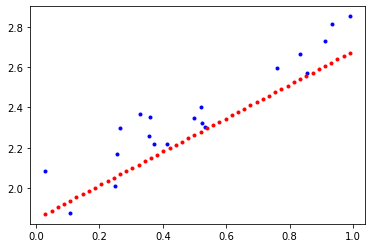

In [ ]:
# Plot the learned regression model

print("w:{},  trained w:{}".format(w,linear_regression.w.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=[np.linspace(min(x_train), max(x_train),50)]
plt.plot(x_linear_regression, linear_regression.w*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Load the reuters dataset and define the class_names 

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])

In [ ]:
# Print the first data example sentence

text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])
print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [ ]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

epochs=16
weight_decay = 0.005
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels)).batch(batch_size)

def train(dataset):
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  train_loss_metric = tf.keras.metrics.Mean()

  train_loss_results=[]
  train_accuracy_results=[]
  for epoch in np.arange(epochs):
    for step, (x, y) in enumerate(train_dataset):
      loss_value, grads = grad(model, x, y, weight_decay)
      # Processing aggregated gradients.
      optimizer.apply_gradients(zip(grads,  model.trainable_variables), experimental_aggregate_gradients=False)
      
      # Update training metric.
      train_acc_metric.update_state(y, model(x))
      train_loss_metric.update_state(loss_value)

      # Log every 200 batches.
      if step % 100 == 0:
          print(
              "Training loss (for one batch) at step %d: %.4f"
              % (step, float(loss_value))
          )
          print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    train_loss = train_loss_metric.result()
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()
    train_accuracy_results.append(train_acc)
    train_loss_results.append(train_loss)
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    print("Training loss over epoch: %.4f" % (float(train_loss),))
  return train_loss_results, train_accuracy_results

In [ ]:
# Define the custom layers and model

class SimpleDense(Layer):
  def __init__(self, units):
    super(SimpleDense, self).__init__()
    self.units = units
  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer=tf.random_normal_initializer(), name='kernel')
    self.b = self.add_weight(shape=(self.units), initializer=tf.zeros_initializer(), name='bias')
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):
  def __init__(self, rate):
    super(MyDropout, self).__init__()
    self.rate = rate
      
  def call(self, inputs, training):
    # Define forward pass for dropout layer
    if (training):
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MyModel(Model):
  def __init__(self, units_1, units_2, units_3):
    super(MyModel, self).__init__()
    # Define layers
    self.dense_1 = SimpleDense(units_1)
    self.dropout_1 = MyDropout(0.7)
    self.dense_2 = SimpleDense(units_2)
    self.dropout_2 = MyDropout(0.7)
    self.dense_3 = SimpleDense(units_3)
  def call(self, inputs, training):
    # Define forward pass
    h = self.dense_1(inputs)
    h = self.dropout_1(h, training=training)
    h = self.dense_2(h)
    h = self.dropout_2(h, training=training)
    return tf.nn.softmax(self.dense_3(h))

In [ ]:
model = MyModel(16, 16, len(class_names))  
model(np.asarray([x_train[0]]))
model.summary()

Model: "my_model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_dense_25 (SimpleDense multiple                  160016    
_________________________________________________________________
my_dropout_14 (MyDropout)    multiple                  0         
_________________________________________________________________
simple_dense_26 (SimpleDense multiple                  272       
_________________________________________________________________
my_dropout_15 (MyDropout)    multiple                  0         
_________________________________________________________________
simple_dense_27 (SimpleDense multiple                  782       
Total params: 161,070
Trainable params: 161,070
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = time.time()
train_loss_results, train_accuracy_results = train(train_dataset)
print("Duration :{:.3f}".format(time.time() - start_time))

Training loss (for one batch) at step 0: 5.8518
Seen so far: 32 samples
Training loss (for one batch) at step 100: 2.2301
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 1.6487
Seen so far: 6432 samples
Training acc over epoch: 0.4325
Training loss over epoch: 2.5859
Training loss (for one batch) at step 0: 1.2715
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.6354
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 1.3380
Seen so far: 6432 samples
Training acc over epoch: 0.5957
Training loss over epoch: 1.7739
Training loss (for one batch) at step 0: 1.1425
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.5312
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 1.2417
Seen so far: 6432 samples
Training acc over epoch: 0.6593
Training loss over epoch: 1.6562
Training loss (for one batch) at step 0: 1.1475
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.4346
Seen so far

#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    weight_decay = 0.01
    loss_value = loss(model, x, y, weight_decay)
    # Compute current loss
    epoch_loss_avg(loss_value)
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 2.030
Test accuracy: 70.614%


#### Plot the learning curves

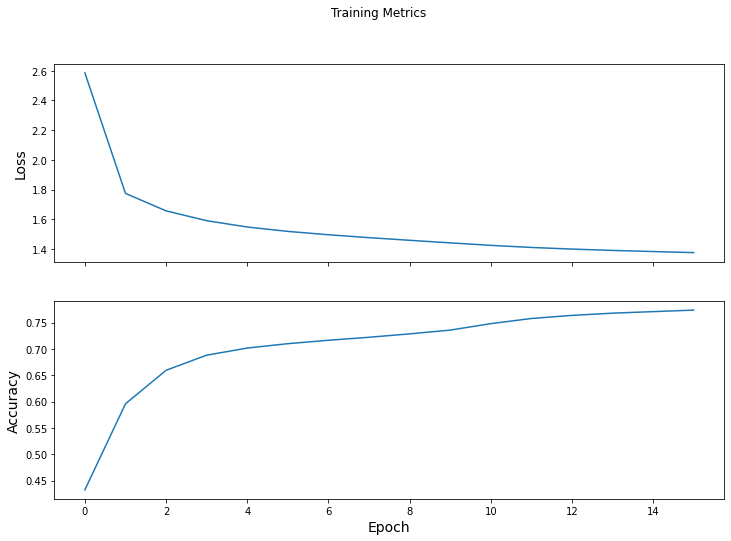

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model

model = MyModel(16, 16, len(class_names))

#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [ ]:
# Re-run the training loop

start_time = time.time()
train(train_dataset)
print("Duration :{:.3f}".format(time.time() - start_time))

Training loss (for one batch) at step 0: 7.8452
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.8143
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 1.5320
Seen so far: 6432 samples
Training acc over epoch: 0.5596
Training loss over epoch: 2.1987
Training loss (for one batch) at step 0: 1.3244
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.6477
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 1.4145
Seen so far: 6432 samples
Training acc over epoch: 0.6583
Training loss over epoch: 1.8311
Training loss (for one batch) at step 0: 1.3280
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.5597
Seen so far: 3232 samples
Training loss (for one batch) at step 200: 1.3584
Seen so far: 6432 samples
Training acc over epoch: 0.6823
Training loss over epoch: 1.7666
Training loss (for one batch) at step 0: 1.3255
Seen so far: 32 samples
Training loss (for one batch) at step 100: 1.5068
Seen so far

#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

